In [175]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from collections import defaultdict

import surprise as sp

import seaborn as sns

from collections import defaultdict

import random

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

plt.style.use('seaborn-whitegrid')

## Functions

In [179]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, true_r, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [180]:
def true_positives(ranking, ideal_ranking):
    tp = 0
    for p in ranking:
        if p in ideal_ranking:
            tp += 1
    return tp

def false_positives(ranking, ideal_ranking):
    fp = 0
    for p in ranking:
        if p not in ideal_ranking:
            fp += 1
    return fp

def false_negatives(ranking, ideal_ranking):
    fn = 0
    for p in ideal_ranking:
        if p not in ranking:
            fn += 1
    return fn

def precision(ranking, ideal_ranking):
    ranked_items = get_items(ranking)
    ideal_items = get_items(ideal_ranking)
    
    tp = true_positives(ranked_items, ideal_items)
    fp = false_positives(ranked_items, ideal_items)
    
    return tp / len(ranking)

def recall(ranking, ideal_ranking):
    ranked_items = get_items(ranking)
    ideal_items = get_items(ideal_ranking)
    
    tp = true_positives(ranked_items, ideal_items)
    fn = false_negatives(ranked_items, ideal_items)
    
    return tp / (tp + fn)

def get_items(ranking):
    return list(map(lambda t: t[0], ranking))

def arhr(ranking, ideal_ranking):
    p = 1
    arhr = 0
    
    ranked_items = get_items(ranking)
    ideal_items = get_items(ideal_ranking)
    
    for r in ranked_items:
        if r in ideal_items:
            arhr += 1 / p
        p += 1
        
    return arhr / (p-1)

def dcg(ranking):
    result = 0
    position = 1
    
    discounter = lambda x: 1/np.log(1+x)
    
    for item_id, score, est in ranking:
        result += score * discounter(position)
        position += 1
    
    return result

def ndcg(ranking, ideal_ranking):
    return dcg(ranking) / dcg(ideal_ranking)

In [230]:
def construct_testset(data, min_ratings):
    total_rated = defaultdict(int)

    for u, _, _ in data:
        total_rated[u] += 1
        
    ratings = dict(filter(lambda i: i[1] >= min_ratings, total_rated.items()))
    
    return [i for i in data if i[0] in ratings.keys()]

def get_users(testset):
    return set({i[0] for i in testset})

In [182]:
def ideal_rankings(testset):
    rankings = defaultdict(list)

    for u_id, item_id, score in testset:
        rankings[u_id].append((item_id, score, score))
        
    for u_id in rankings.keys():
        rankings[u_id] = sorted(rankings[u_id], key=lambda t: t[1], reverse=True)
        
    return rankings

In [418]:
def evaluate_algo(algo, metric, testset, n_values):
    predictions = algo.test(testset)
    ideal_list = ideal_rankings(testset)
    
    result = []

    for n in n_values:
        top_n = get_top_n(predictions, n=n)
        
        metric_values = []
        for u in get_users(testset):
            r = top_n[str(u)][0:n]
            r_id = ideal_list[str(u)][0:n]
    
            if len(r) == 0 or len(r_id) == 0:
                print('No ratings for user '+str(u))
                continue
                        
            metric_values.append(metric(r, r_id))
        
        result.append(np.mean(metric_values))
    
    return result

In [460]:
def rank_rs(algos, metric_values, n):
    result = {}
    for a in algos:
        result[a] = metric_values[a][n]
        
    return [(k, result[k]) for k in sorted(result, key=result.get, reverse=True)]

## Load data

In [491]:
# Load the full dataset.
data = sp.Dataset.load_builtin('ml-100k')
raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A
trainset = data.build_full_trainset()

testset = data.construct_testset(B_raw_ratings)

In [492]:
# Construct testset

min_ratings = 17

restricted_testset = construct_testset(testset, min_ratings=min_ratings)

ratings_df = pd.DataFrame(restricted_testset, columns=["user_id","item_id","rating"])

print('%d users with a minimum of %d ratings. Total number of ratings %d' % (ratings_df["user_id"].nunique(), min_ratings, len(ratings_df)))

411 users with a minimum of 17 ratings. Total number of ratings 15820


## Data exploration

In [493]:
number_of_ratings = range(1,70)
ratings_users = []

for count in number_of_ratings:
    data = construct_testset(testset, min_ratings=count)
    ratings_users.append({"min_ratings": count, "total_users": len(get_users(data))})
    
dataframe = pd.DataFrame(ratings_users)

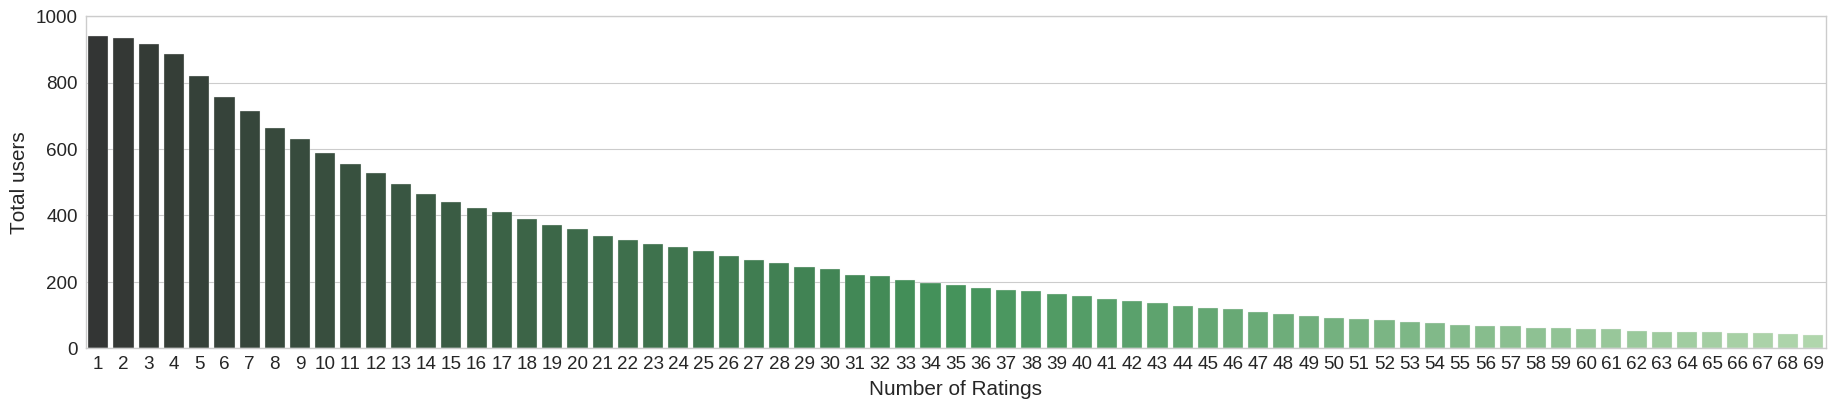

In [494]:
with sns.axes_style("whitegrid"):
    sns.set_context("paper", font_scale=1.7, rc={"lines.linewidth": 1.5})
    
    plt.figure(figsize=(20, 4))

    g = sns.barplot(x="min_ratings", y="total_users", data=dataframe, palette="Greens_d")
    
    g.set_ylabel("Total users")
    g.set_xlabel("Number of Ratings")
                
    plt.show()

In [302]:
ratings_df.shape

(4778, 3)

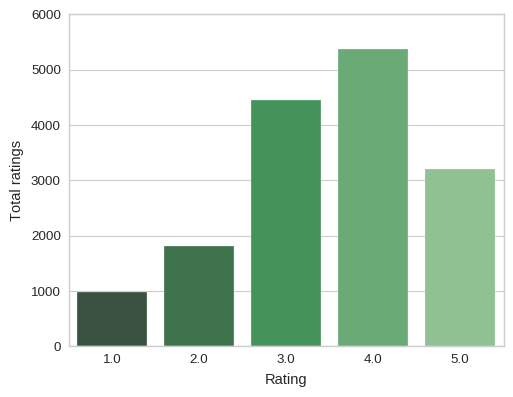

In [495]:
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 1.5})
    
plt.figure(figsize=(5, 4))

g = sns.countplot(x="rating", data=ratings_df, palette="Greens_d")
    
g.set_ylabel("Total ratings")
g.set_xlabel("Rating")
                
plt.show()

## Train RSs

In [496]:
svd = sp.SVD()
svd.train(trainset)

In [497]:
svdpp = sp.SVDpp()
svdpp.train(trainset)

In [498]:
nmf = sp.NMF()
nmf.train(trainset)

In [499]:
knn_pearson = sp.KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based': True})
knn_pearson.train(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [500]:
knn_cosine = sp.KNNBaseline(sim_options={'name': 'cosine', 'user_based': True})
knn_cosine.train(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [501]:
normal_predictor = sp.NormalPredictor()
normal_predictor.train(trainset)

In [502]:
knnMeans = sp.KNNWithMeans(sim_options={'name': 'pearson_baseline', 'user_based': True})
knnMeans.train(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [503]:
knnBaseline = sp.KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based': True})
knnBaseline.train(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [504]:
slopeOne = sp.SlopeOne()
slopeOne.train(trainset)

In [505]:
coClustering = sp.CoClustering()
coClustering.train(trainset)

In [506]:
algos = [svd, svdpp, nmf, knn_pearson, knn_cosine, normal_predictor]
names = ['SVD', 'SVD++', 'NMF', 'k-NN with Pearson', 'k-NN with Cosine', 'random']

In [527]:
ideal_list = ideal_rankings(restricted_testset)
predictions = get_top_n(svd.test(restricted_testset), 1)

In [543]:
sp.accuracy.rmse(knn_pearson.test(restricted_testset))

RMSE: 0.9014


0.90135428928824324

In [544]:
sp.accuracy.mae(svdpp.test(restricted_testset))

RMSE: 0.8982


0.89817876161772381

In [529]:
get_top_n(svd.test(restricted_testset), 1)

defaultdict(list,
            {'1': [('168', 5.0, 4.7099284140645885)],
             '10': [('178', 5.0, 4.8664274411445376)],
             '102': [('316', 3.0, 3.7552272738316468)],
             '104': [('346', 3.0, 3.1673589605221704)],
             '109': [('79', 5.0, 4.5615399537218986)],
             '11': [('185', 4.0, 4.213028410707282)],
             '110': [('692', 4.0, 3.5401685310493969)],
             '116': [('50', 3.0, 4.1322266867748327)],
             '119': [('172', 4.0, 4.643267887770933)],
             '121': [('357', 5.0, 4.1909513397208089)],
             '125': [('50', 5.0, 4.6658840505209271)],
             '128': [('64', 5.0, 4.6608458294420352)],
             '13': [('175', 4.0, 4.6868623531750648)],
             '130': [('272', 5.0, 5)],
             '14': [('195', 5.0, 4.5321810252462837)],
             '141': [('313', 5.0, 4.3366999364872978)],
             '144': [('176', 4.0, 4.3844483993765806)],
             '145': [('89', 4.0, 4.8416818523700416)],
    

In [530]:
get_top_n(svdpp.test(restricted_testset), 1)

defaultdict(list,
            {'1': [('187', 4.0, 5)],
             '10': [('174', 4.0, 4.7600691706133462)],
             '102': [('316', 3.0, 3.4792326313419917)],
             '104': [('117', 2.0, 3.3122608967701925)],
             '109': [('173', 5.0, 5)],
             '11': [('185', 4.0, 4.2287854717213182)],
             '110': [('79', 4.0, 3.7005687839607897)],
             '116': [('50', 3.0, 4.0409157736796981)],
             '119': [('742', 5.0, 4.6235498729935447)],
             '121': [('357', 5.0, 4.4140732563956764)],
             '125': [('50', 5.0, 5)],
             '128': [('64', 5.0, 4.5893436914936094)],
             '13': [('172', 5.0, 5)],
             '130': [('69', 5.0, 5)],
             '14': [('427', 5.0, 4.6169433035856207)],
             '141': [('313', 5.0, 4.937911421596187)],
             '144': [('172', 4.0, 4.4610631867907333)],
             '145': [('96', 5.0, 5)],
             '15': [('310', 4.0, 3.82394750726698)],
             '151': [('302', 3.0, 5)

In [525]:
ideal_list

defaultdict(list,
            {'1': [('91', 5.0, 5.0),
              ('93', 5.0, 5.0),
              ('14', 5.0, 5.0),
              ('224', 5.0, 5.0),
              ('96', 5.0, 5.0),
              ('166', 5.0, 5.0),
              ('235', 5.0, 5.0),
              ('268', 5.0, 5.0),
              ('191', 5.0, 5.0),
              ('269', 5.0, 5.0),
              ('168', 5.0, 5.0),
              ('82', 5.0, 5.0),
              ('43', 4.0, 4.0),
              ('249', 4.0, 4.0),
              ('76', 4.0, 4.0),
              ('203', 4.0, 4.0),
              ('187', 4.0, 4.0),
              ('227', 4.0, 4.0),
              ('267', 4.0, 4.0),
              ('234', 4.0, 4.0),
              ('135', 4.0, 4.0),
              ('222', 4.0, 4.0),
              ('65', 4.0, 4.0),
              ('90', 4.0, 4.0),
              ('84', 4.0, 4.0),
              ('47', 4.0, 4.0),
              ('192', 4.0, 4.0),
              ('97', 3.0, 3.0),
              ('92', 3.0, 3.0),
              ('67', 3.0, 3.0),
 

In [523]:
ideal_list = ideal_rankings(restricted_testset)
predictions = get_top_n(svdpp.test(restricted_testset), 1)

In [558]:
[(name, score) for name, score in rank_rs(names, arhr_values, 16)]

[('SVD++', 0.15164134850379893),
 ('k-NN with Pearson', 0.15124253429540982),
 ('SVD', 0.14987712311355381),
 ('k-NN with Cosine', 0.14941703147793872),
 ('NMF', 0.14492252088007651),
 ('random', 0.11355479394147847)]

In [559]:
[(name, score) for name, score in rank_rs(names, ndcg_values, 16)]

[('k-NN with Pearson', 0.90589777765682022),
 ('SVD++', 0.90526303733171476),
 ('SVD', 0.90069331598869962),
 ('k-NN with Cosine', 0.90024311728774287),
 ('NMF', 0.88927204514447966),
 ('random', 0.80581537150310845)]

In [560]:
[(name, score) for name, score in rank_rs(names, precisions, 16)]

[('k-NN with Pearson', 0.68455703449262917),
 ('SVD++', 0.67840274796049815),
 ('SVD', 0.67625590382138256),
 ('k-NN with Cosine', 0.675110920280521),
 ('NMF', 0.66451982252755115),
 ('random', 0.54887648490052954)]

## Evaluate RSs

In [545]:
precisions = {}
for name, algo in zip(names, algos):
    precisions[name] = evaluate_algo(algo, precision, restricted_testset, range(1, min_ratings+1))

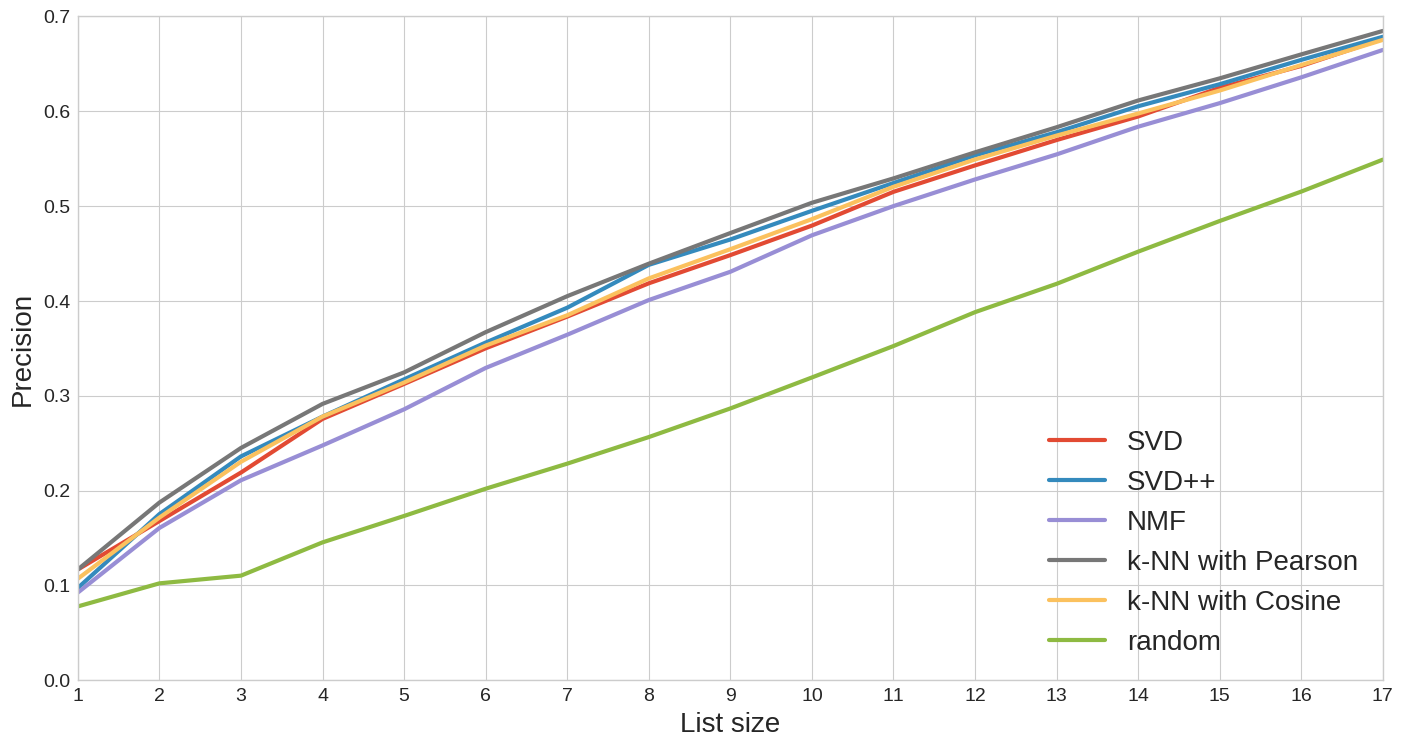

In [546]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=100)

for name, values in precisions.items():
    ax.plot(range(1,min_ratings+1), values, label=name, linewidth=3.0)

plt.xlabel("List size", fontsize=20)
plt.ylabel("Precision", fontsize=20)

ax.set_xlim([1, 17])
ax.tick_params(labelsize=14)

plt.xticks(range(1, min_ratings+1, 1))

plt.legend(loc="lower right", fontsize=20)
plt.show()

In [547]:
arhr_values = {}
for name, algo in zip(names, algos):
    arhr_values[name] = evaluate_algo(algo, arhr, restricted_testset, range(1, min_ratings+1))

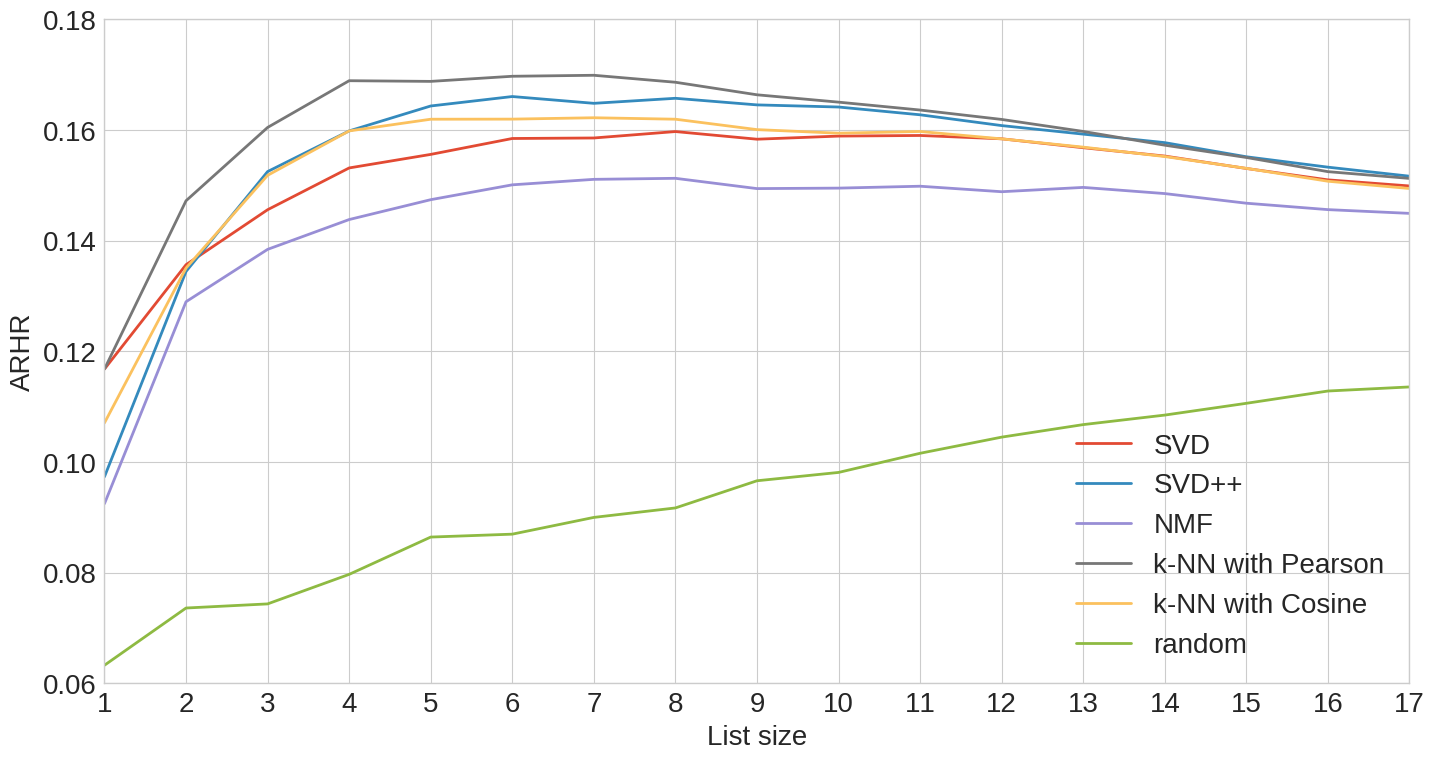

In [548]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=100)

for name, values in arhr_values.items():
    ax.plot(range(1,min_ratings+1), values, label=name, linewidth=2.0)

plt.xlabel("List size", fontsize=20)
plt.ylabel("ARHR", fontsize=20)

ax.set_xlim([1, 17])
ax.tick_params(labelsize=20)

plt.xticks(range(1, min_ratings+1, 1))

plt.legend(loc="lower right", fontsize=20)
plt.show()

In [549]:
ndcg_values = {}
for name, algo in zip(names, algos):
    ndcg_values[name] = evaluate_algo(algo, ndcg, restricted_testset, range(1, min_ratings+1))

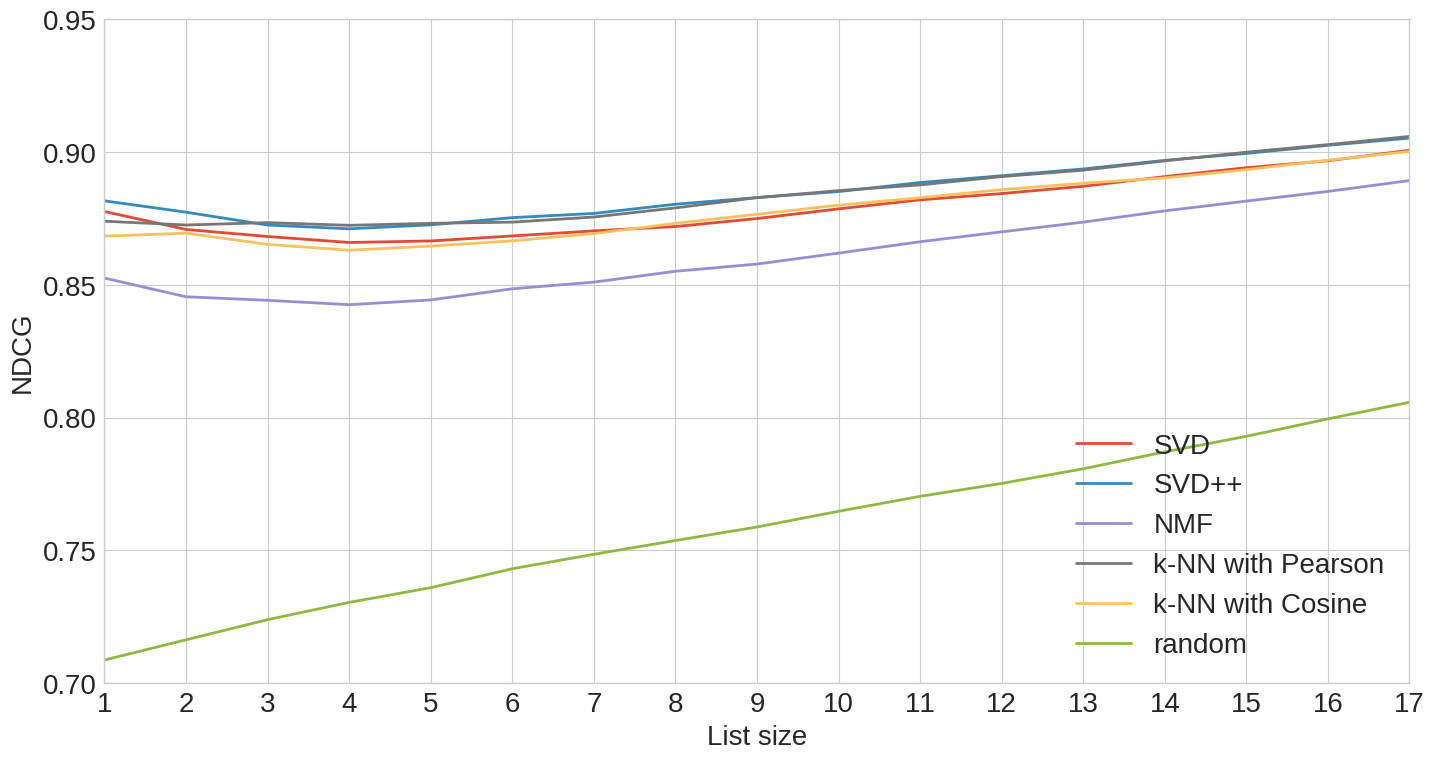

In [550]:
fig, ax = plt.subplots(figsize=(15, 8), dpi=100)

for name, values in ndcg_values.items():
    ax.plot(range(1,min_ratings+1), values, label=name, linewidth=2.0)

plt.xlabel("List size", fontsize=20)
plt.ylabel("NDCG", fontsize=20)

ax.set_xlim([1, 17])
ax.tick_params(labelsize=20)

plt.xticks(range(1, min_ratings+1, 1))

plt.legend(loc="lower right", fontsize=20)
plt.show()

# Explore different set up of kNN

In [256]:
# Cosine

sim_options = {'name': 'cosine', 'user_based': True}

knn = sp.KNNBaseline(sim_options=sim_options)
knn.train(trainset)

precisions_knn_cosine = evaluate_algo(knn, precision, restricted_testset, range(1, n+1))
arhr_knn_cosine = evaluate_algo(knn, arhr, restricted_testset, range(1, n+1))
ndcg_knn_cosine = evaluate_algo(knn, ndcg, restricted_testset, range(1, n+1))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [257]:
# Pearson

sim_options = {'name': 'pearson', 'user_based': True}

knn = sp.KNNBaseline(sim_options=sim_options)
knn.train(trainset)

precisions_knn_pearson = evaluate_algo(knn, precision, restricted_testset, range(1, n+1))
arhr_knn_pearson = evaluate_algo(knn, arhr, restricted_testset, range(1, n+1))
ndcg_knn_pearson = evaluate_algo(knn, ndcg, restricted_testset, range(1, n+1))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [258]:
# MSD

sim_options = {'name': 'msd', 'user_based': True}

knn = sp.KNNBaseline(sim_options=sim_options)
knn.train(trainset)

precisions_knn_msd = evaluate_algo(knn, precision, restricted_testset, range(1, n+1))
arhr_knn_msd = evaluate_algo(knn, arhr, restricted_testset, range(1, n+1))
ndcg_knn_msd = evaluate_algo(knn, ndcg, restricted_testset, range(1, n+1))

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [263]:
# Pearson + Shrinkage

sim_options = {'name': 'pearson_baseline', 'user_based': True, 'shrinkage': 100}

knn = sp.KNNBaseline(k=25, sim_options=sim_options)
knn.train(trainset)

precisions_knn_pb = evaluate_algo(knn, precision, restricted_testset, range(1, n+1))
arhr_knn_pb = evaluate_algo(knn, arhr, restricted_testset, range(1, n+1))
ndcg_knn_pb = evaluate_algo(knn, ndcg, restricted_testset, range(1, n+1))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


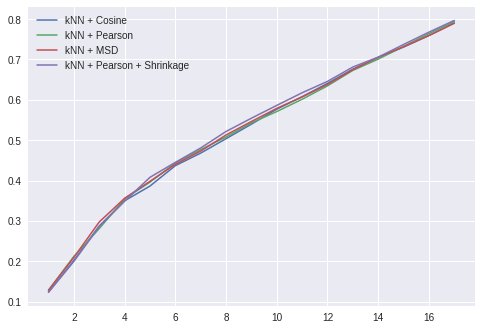

In [260]:
plt.plot(range(1,n+1), precisions_knn_cosine, label='kNN + Cosine')
plt.plot(range(1,n+1), precisions_knn_pearson, label='kNN + Pearson')
plt.plot(range(1,n+1), precisions_knn_msd, label='kNN + MSD')
plt.plot(range(1,n+1), precisions_knn_pb, label='kNN + Pearson + Shrinkage')

plt.legend()
plt.show()

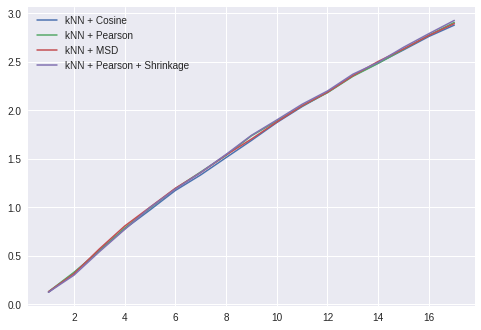

In [261]:
plt.plot(range(1,n+1), arhr_knn_cosine, label='kNN + Cosine')
plt.plot(range(1,n+1), arhr_knn_pearson, label='kNN + Pearson')
plt.plot(range(1,n+1), arhr_knn_msd, label='kNN + MSD')
plt.plot(range(1,n+1), arhr_knn_pb, label='kNN + Pearson + Shrinkage')

plt.legend()
plt.show()

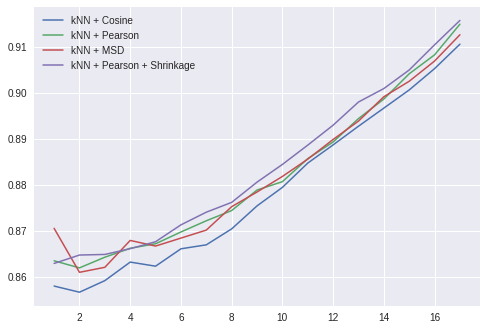

In [264]:
plt.plot(range(1,n+1), ndcg_knn_cosine, label='kNN + Cosine')
plt.plot(range(1,n+1), ndcg_knn_pearson, label='kNN + Pearson')
plt.plot(range(1,n+1), ndcg_knn_msd, label='kNN + MSD')
plt.plot(range(1,n+1), ndcg_knn_pb, label='kNN + Pearson + Shrinkage')

plt.legend()
plt.show()

In [225]:
ndcg_knn_pb

[0.99040369818541873,
 0.99098836621233521,
 0.99357268535998411,
 0.99548755619383988,
 0.99585023554238061,
 0.99747294354692928,
 0.99813415321650889,
 0.99864697727101226,
 0.99949773577947132,
 1.0003959171775318,
 1.0018153137908457,
 1.0025925061280485,
 1.0031199558512922,
 1.0035961942187153,
 1.0039722925085703,
 1.0044282115833474,
 1.0047788452954878]